In [1]:
import sys
import numpy as np
import os
from os.path import abspath

import matplotlib.pyplot as plt
%matplotlib inline

import subtle.subtle_preprocess as sup
import subtle.subtle_plot as suplot
import subtle.subtle_io as suio

import SimpleITK as sitk

Using TensorFlow backend.


In [2]:
base_path = '/home/subtle/Data/Tiantan_Batch1/Brain1H-600444022'
base_path = '/home/subtle/Data/Tiantan_Batch1/Brain3H-600437593'
base_path = '/home/subtle/Data/Tiantan_Batch1/Brain4H-601044594/'
base_path = '/home/subtle/Data/Tiantan/NO30'
base_path = '/home/subtle/Data/Tiantan/NO29'
# base_path = '/home/subtle/Data/Tiantan/NO10'
# base_path = '/home/subtle/Data/Tiantan/NO47'

path_zero, path_low, path_high = suio.get_dicom_dirs(base_path, override=True)
print(path_zero, path_low, path_high)

/home/subtle/Data/Tiantan/NO29/3DT1WMPRAGE_SAG_CS4_301 /home/subtle/Data/Tiantan/NO29/3DT1WMPRAGE_SAG_CS4_601 /home/subtle/Data/Tiantan/NO29/3DT1WMPRAGE_SAG_CS4_701


In [3]:
im0, hd0 = suio.dicom_files(path_zero, normalize=False)
im1, hd1 = suio.dicom_files(path_low, normalize=False)
im2, hd2 = suio.dicom_files(path_high, normalize=False)
print(im0.shape, im1.shape, im2.shape)

(196, 240, 240) (196, 240, 240) (196, 240, 240)


In [4]:
rescale_slope_0 = float(hd0.RescaleSlope)
rescale_intercept_0 = float(hd0.RescaleIntercept)
scale_slope_0 = hd0[0x2005, 0x100e].value

rescale_slope_1 = float(hd1.RescaleSlope)
rescale_intercept_1 = float(hd1.RescaleIntercept)
scale_slope_1 = hd1[0x2005, 0x100e].value

rescale_slope_2 = float(hd2.RescaleSlope)
rescale_intercept_2 = float(hd2.RescaleIntercept)
scale_slope_2 = hd2[0x2005, 0x100e].value

In [5]:
print(rescale_slope_0, rescale_slope_1, rescale_slope_2)
print(rescale_intercept_0, rescale_intercept_1, rescale_intercept_2)
print(scale_slope_0, scale_slope_1, scale_slope_2)

4.15848595848595 5.56141636141636 2.15824175824175
0.0 0.0 0.0
0.004859284497797489 0.004859284032136202 0.004859284032136202


In [6]:
print(np.mean(im0))
print(np.mean(sup.scale_slope_intercept(im0, rescale_slope_0, rescale_intercept_0, scale_slope_0)))
print(np.mean(sup.rescale_slope_intercept(sup.scale_slope_intercept(im0, rescale_slope_0, rescale_intercept_0, scale_slope_0), rescale_slope_0, rescale_intercept_0, scale_slope_0)))

55.98731
11521.713
55.9873


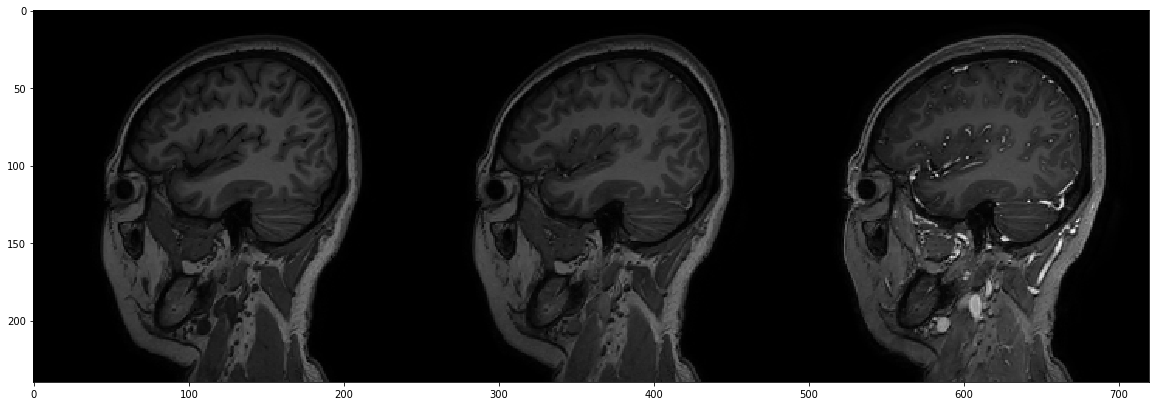

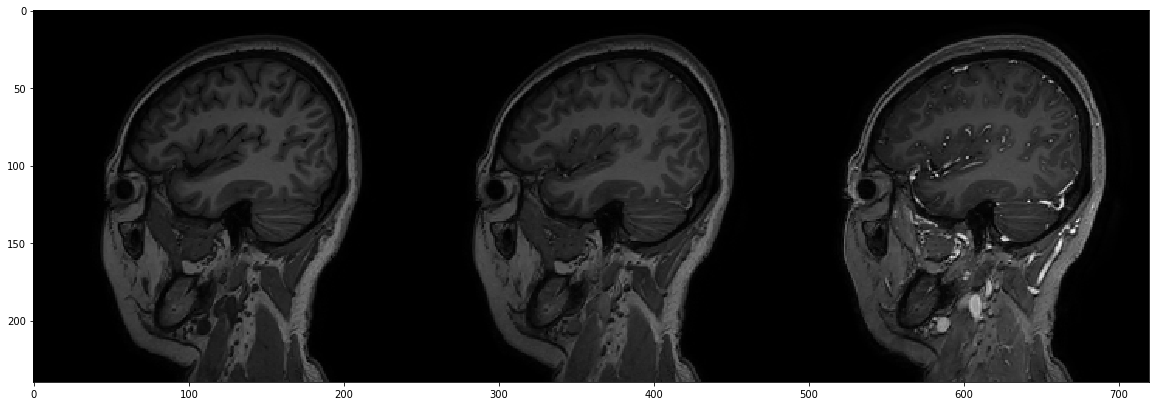

In [7]:
im0_rescale = sup.scale_slope_intercept(im0, rescale_slope_0, rescale_intercept_0, scale_slope_0)
im1_rescale = sup.scale_slope_intercept(im1, rescale_slope_1, rescale_intercept_1, scale_slope_1)
im2_rescale = sup.scale_slope_intercept(im2, rescale_slope_2, rescale_intercept_2, scale_slope_2)

idx = 60
plt.figure(figsize=(20,10))
suplot.imshowtile(np.stack((im0[idx,...], im1[idx,...], im2[idx,...]), axis=2))

plt.figure(figsize=(20,10))
suplot.imshowtile(np.stack((im0_rescale[idx,...], im1_rescale[idx,...], im2_rescale[idx,...]), axis=2))

In [8]:
spars = sitk.GetDefaultParameterMap('rigid')
im1_reg_rescale, p1_reg = sup.register_im(im0_rescale, im1_rescale, param_map=spars)
im2_reg_rescale, p2_reg = sup.register_im(im0_rescale, im2_rescale, param_map=spars)

image registration
registration done, 7.03 s
image registration
registration done, 7.57 s


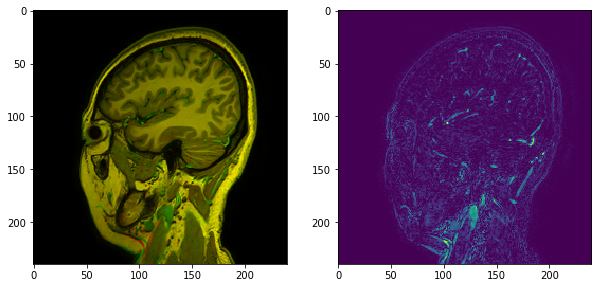

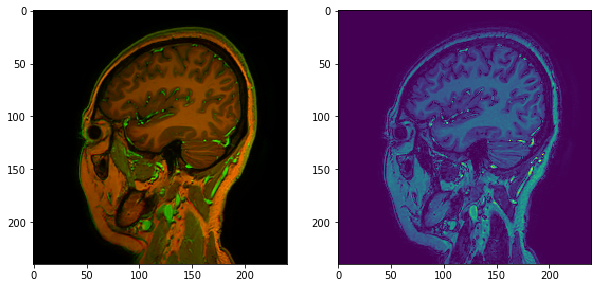

In [9]:
plt.figure(figsize=(10,6))
suplot.imshowreg(im0_rescale[idx,...], im1_rescale[idx,...])
plt.figure(figsize=(10,6))
suplot.imshowreg(im0_rescale[idx,...], im2_rescale[idx,...])


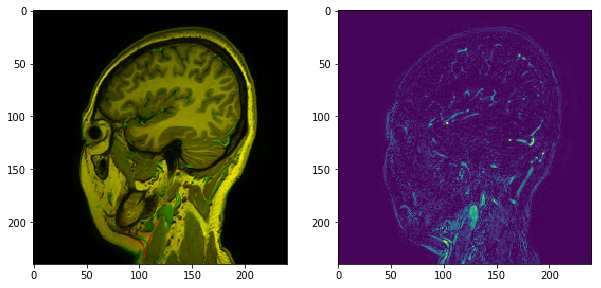

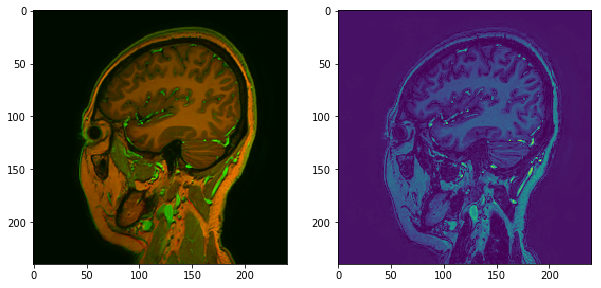

In [10]:
plt.figure(figsize=(10,6))
suplot.imshowreg(im0_rescale[idx,...], im1_reg_rescale[idx,...])
plt.figure(figsize=(10,6))
suplot.imshowreg(im0_rescale[idx,...], im2_reg_rescale[idx,...])

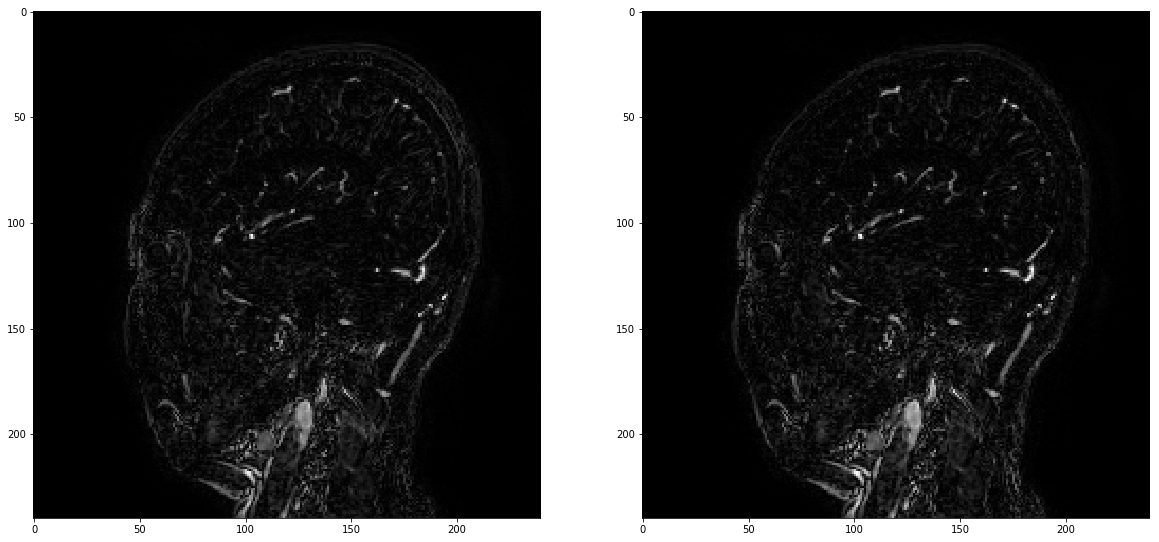

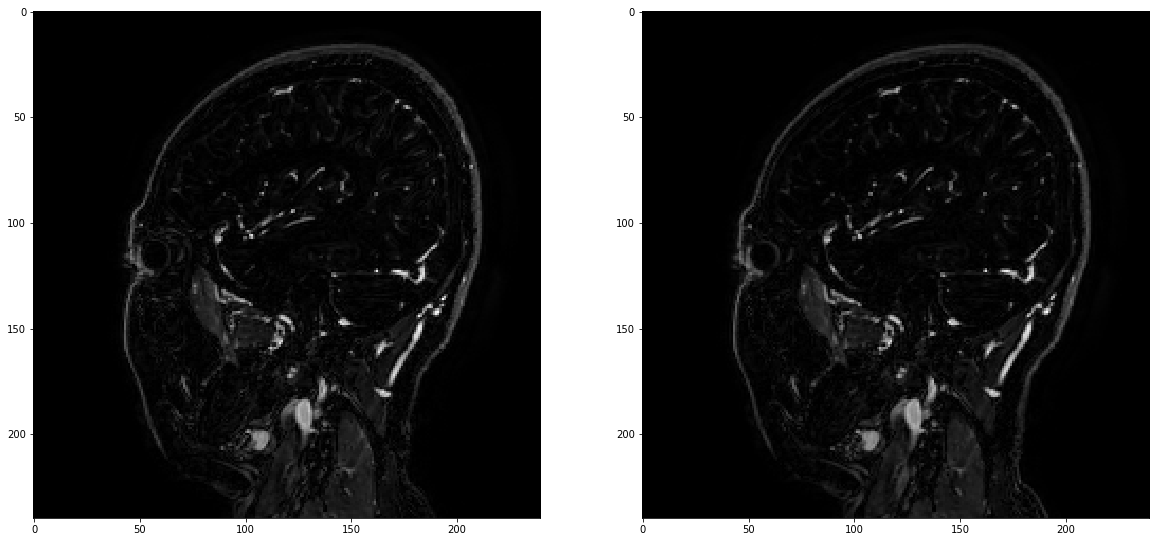

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(abs(im1_rescale[idx,...] - im0_rescale[idx,...]), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(abs(im1_reg_rescale[idx,...] - im0_rescale[idx,...]), cmap='gray')

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(abs(im2_rescale[idx,...] - im0_rescale[idx,...]), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(abs(im2_reg_rescale[idx,...] - im0_rescale[idx,...]), cmap='gray')

In [12]:
from scipy.ndimage.morphology import binary_fill_holes
threshold = .05
im = np.stack((im0_rescale, im1_reg_rescale, im2_reg_rescale), axis=1)
N, n, nx, ny = im.shape
mask = im > (threshold * np.amax(im, axis=(2,3))[:,:,None,None])
mask = binary_fill_holes(mask.reshape((n*N*nx, ny))).reshape((N, n, nx, ny))

nslices = 50
ns = im0_rescale.shape[0]
idx_scale = range(ns//2 - nslices // 2, ns//2 + nslices // 2)
im0 = im0_rescale[idx_scale, ...]
im1 = im1_reg_rescale[idx_scale, ...]
im2 = im2_reg_rescale[idx_scale, ...]
m = mask[idx_scale,0,...]
im0 = im0[m != 0].ravel()
im1 = im1[m != 0].ravel()
im2 = im2[m != 0].ravel()
_ims = np.stack((im0, im1, im2), axis=1)

print(_ims.shape)

(1783764, 3)


In [13]:
print('intensity before scaling:')
print('mean', np.mean(np.abs(_ims), axis=(0)))
print('median', np.median(np.abs(_ims), axis=(0)))
print('max', np.max(np.abs(_ims), axis=(0)))

intensity before scaling:
mean [31172.863 32957.906 44212.12 ]
median [29428.197 31943.965 42987.67 ]
max [136028.25 134329.03 301863.03]


In [14]:
scale_global = sup.normalize_scale(_ims[...,0], axis=(0), fun=np.mean)
print(scale_global)

[31165.797]


intensity after scaling:
mean [1.0000105 1.0574993 1.4185578]
median [0.9442466 1.0249686 1.379322 ]
max [4.3646646 4.3101425 9.685715 ]


(0, 10)

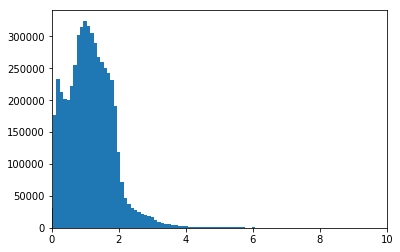

In [15]:
_ims = _ims / scale_global

print('intensity after scaling:')
print('mean', np.mean(np.abs(_ims), axis=(0)))
print('median', np.median(np.abs(_ims), axis=(0)))
print('max', np.max(np.abs(_ims), axis=(0)))

plt.figure()
plt.hist(_ims.ravel(), 100);
plt.xlim([0, 10])

In [16]:
# base_path = '/home/subtle/Data/Tiantan/NO30'
# intensity before scaling:
# mean [31172.863 32957.906 44212.12 ]
# median [29428.197 31943.965 42987.67 ]
# max [136028.25 134329.03 301863.03]
# [31165.797]
# intensity after scaling:
# mean [1.0000105 1.0574993 1.4185578]
# median [0.9442466 1.0249686 1.379322 ]
# max [4.3646646 4.3101425 9.685715 ]

# base_path = '/home/subtle/Data/Tiantan/NO29'
# intensity before scaling:
# mean [34039.99  35992.82  47106.945]
# median [31791.719 34272.703 43833.562]
# max [124910.695 150104.73  312999.47 ]
# [34006.477]
# intensity after scaling:
# mean [1.0000786 1.0584109 1.3852217]
# median [0.93487245 1.0078287  1.2889769 ]
# max [3.6731443 4.4140043 9.204113 ]

# base_path = '/home/subtle/Data/Tiantan_Batch1/Brain4H-601044594/'
# intensity before scaling:
# mean [37898.234 40311.918 55722.06 ]
# median [35381.02  39277.355 54453.664]
# max [132089.14 135565.56 315032.6 ]
# [37894.996]
# intensity after scaling:
# mean [0.99972135 1.0637423  1.4704034 ]
# median [0.93365943 1.0364786  1.4369619 ]
# max [3.4856617 3.5774002 8.313303 ]

# base_path = '/home/subtle/Data/Tiantan/NO47'
# intensity before scaling:
# mean [34793.082 39922.977 50744.7  ]
# median [33115.18  39339.926 49807.086]
# max [170706.4  208904.78 309629.78]
# [34789.105]
# intensity after scaling:
# mean [1.000161  1.1475738 1.4585255]
# median [0.9518836 1.1308117 1.4316863]
# max [4.906893 6.004891 8.900194]
